## Forward Goldstein Taylor model

Consider the macroscopic formulation of Goldstein-Taylor model in discrete velocity kinetic theory, i.e.

$$\partial_{t}\rho + \partial_{x}j = 0$$

$$\partial_{t}j + {(\frac{c}{\epsilon})}^2\partial_{x}\rho = - \frac{\sigma}{\epsilon^2}j$$

with $x \in \mathbb{R}, t \geq 0,$

$\rho = \rho(x, t)$ total particles density, $j = j(x, t)$ scaled flux, 

$\epsilon$ scaling parameter of the kinetic dynamics and $\sigma$ scattering coefficient.

#### Install libraries

In [1]:
!pip install pinnstorch

!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.8 MB/s eta 0:00:00
  Created wheel for pinnstorch: filename=pinnstorch-0.1.2-py3-none-any.whl size=71563 sha256=f56f1b8d06f82c441cd8a0b1f3fe6d8650bf32d21c192b506897ff1afe11d12c
  Stored in directory: /root/.cache/pip/wheels/17/8b/17/2d6c20d7adb7622724a9c3e3ff5db52d4865c98c9a84e2984b
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=15f814e59c8a8f76ba05bb93da8bc877bde8baa143089cca6f25c076dbca077d
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pinnstorch pyDOE
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 14.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━

#### Import libraries

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from typing import Dict
import torch
import lightning.pytorch as pl
import pinnstorch

In [3]:
# clear output
#!rm -rf /kaggle/working/*

In [4]:
import sys
# path for Github link
package_paths = [
    '/kaggle/input/pinnmt/',
]

for pth in package_paths:
    sys.path.append(pth)

Let $x \in [-1,1],\,\, t \in [0,0.1]$.

In [5]:
m = 400 # discretization for x
n = 4200 # discretization for t
x_disc = np.linspace(-1,1,m+1)
t_disc = np.linspace(0,0.1,n+1)
delta_x = (x_disc[-1] - x_disc[0])/(len(x_disc)-1)
delta_t = (t_disc[-1] - t_disc[0])/(len(t_disc)-1)
print(f"Δx = {delta_x}")
print(f"Δx**2 = {(delta_x)**2}")
print(f"Δt = {delta_t}")
if delta_t < delta_x**2:
    print("CFL condition satisfied")
else:
    print("CFL condition NOT satisifed, please change m and n values")

Δx = 0.005
Δx**2 = 2.5e-05
Δt = 2.380952380952381e-05
CFL condition satisfied


#### Initial Condition



Let's start with initial condition of the model.

$$ \rho(x,\, 0) = 6 + 3\cos(3\pi x)$$

$$ j(x,\, 0) = \frac{9\pi c^2}{\sigma}\sin(3\pi x) $$

In [6]:
c = 1
sigma = 4
eps = 1e-4
rho_0 = 6+3*np.cos(3*np.pi*x_disc)
j_0 = (9*np.pi*(c**2)/sigma)*np.sin(3*np.pi*x_disc)

In [7]:
# import the solver
from Euler_IMEX import solve_E_I

In [8]:
rho_tot, j_tot = solve_E_I(x_disc, t_disc, rho_0, j_0, eps, sigma, c)

In [9]:
T, X = np.meshgrid(t_disc, x_disc)

Since

$\rho = f^+ + f^-$ and $j = \frac{c}{\epsilon}(f^+ - f^-),$

then we have that $\,f^- = \frac{1}{2}(\rho - \frac{\epsilon}{c}j)$ and $f^+ = \rho - f^-.$

In [10]:
f_minus_tot = 0.5*(rho_tot - (eps*j_tot)/c)
f_plus_tot = rho_tot - f_minus_tot

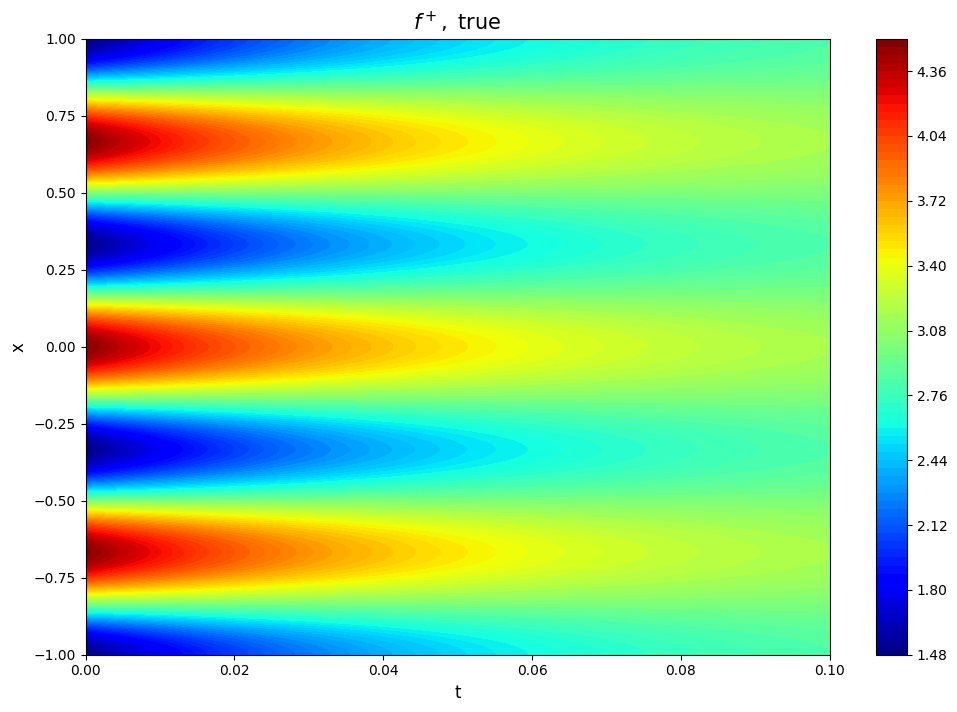

In [11]:
# f_plus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_plus_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^+,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_plus.jpg', dpi=300)

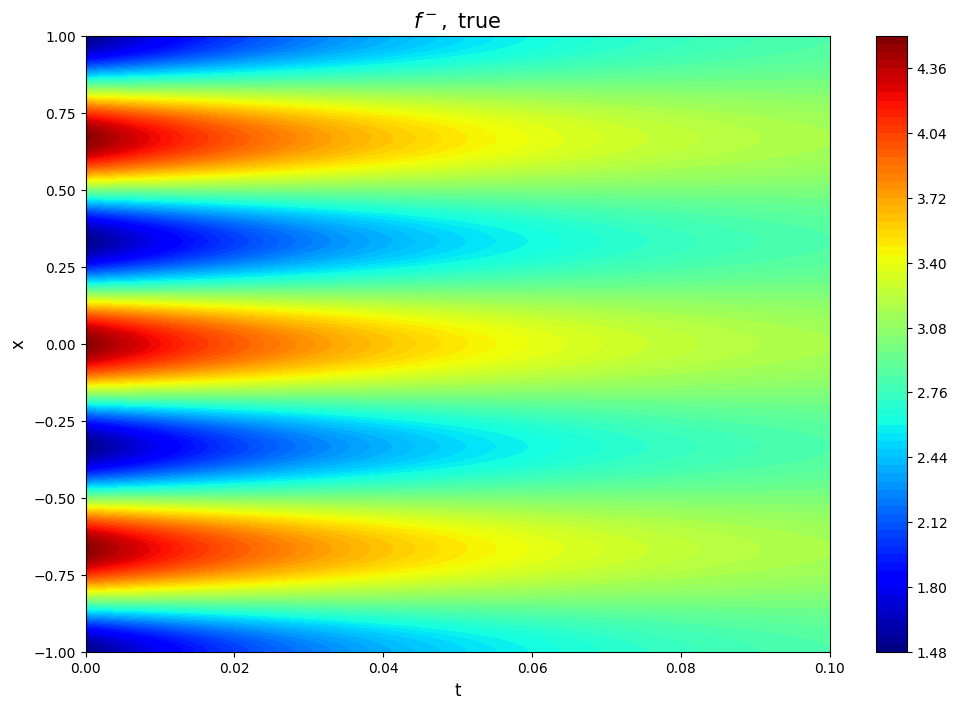

In [12]:
# f_minus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_minus_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^-,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_minus.jpg', dpi=300)

In [13]:
mdic = {"f_plus": f_plus_tot, "f_minus": f_minus_tot, "x": x_disc, "tt": t_disc}
savemat("GT.mat", mdic)

### Define Mesh



Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnstorch`, there are primarily two approaches to define this mesh:





- **Defining Time and Spatial Domains Separately:** Here, we use `pinnstorch.data.TimeDomain` and `pinnstorch.data.Interval` for creating 1-D spatial domains. These domains are then used to define a `pinnstorch.data.Mesh`.



- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnstorch.data.PointCloud`.



Both approaches should ideally yield the same results.

In [14]:
def read_data_fn(root_path):

    """Read and preprocess data from the specified root path.



    :param root_path: The root directory containing the data.

    :return: Processed data will be used in PointCloud class.

    """



    data = pinnstorch.utils.load_data(root_path, "GT.mat")



    x = data["x"].T  # N x 1

    t = data["tt"].T  # T x 1


    exact_f_plus = data["f_plus"] # N x T

    exact_f_minus = data["f_minus"] # N x T



    return pinnstorch.data.PointCloudData(

            spatial=[x], time=[t], solution={"f_plus": exact_f_plus, "f_minus": exact_f_minus}

    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [15]:
mesh = pinnstorch.data.PointCloud(root_dir='/kaggle/working/',

                                  read_data_fn=read_data_fn)

### Define Train datasets

For solving Goldstein Taylor PDE, we must have:

- Initial conditions

- Periodic boundary conditions

- Collection points for the PDE.

#### Initial Condition



Let's start with initial condition of the model.

$$ \rho(x,\, 0) = 6 + 3\cos(3\pi x)$$

$$ j(x,\, 0) = \frac{9\pi c^2}{\sigma}\sin(3\pi x) $$

$$\,f^- = \frac{1}{2}(\rho - \frac{\epsilon}{c}j)$$

$$f^+ = \rho - f^-$$



For defining initial condition, again we have two options.



- **Sample from the data.**

- **Defining a function for calculating initial condition.**

##### Set number of samples

In [16]:
N0 = 200

##### Sample from data

In [17]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,

                                        num_sample = N0,

                                        solution = ['f_plus', 'f_minus'])

#### Periodic Boundary Condition

The `pinnstorch.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Goldstein Taylor equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.





$$ f^+(-1,t) = f^+(1, t), $$

$$ f^-(-1, t) = f^-(1, t), $$

$$ f_{x}^+(-1, t) = f_{x}^+(1, t),$$

$$ f_{x}^-(-1, t) = f_{x}^-(1, t) $$

In [18]:
N_b = 200

pe_b = pinnstorch.data.PeriodicBoundaryCondition(mesh = mesh,

                                                 num_sample = N_b,

                                                 derivative_order = 1,

                                                 solution = ['f_plus', 'f_minus'])

#### Mesh Sampler for collection points and solutions



In our problem, the partial differential equations (PDEs) governing the dynamics are given by:



$$f_{f^+} = \partial_{t}f^+ +\frac{c}{\epsilon}\partial_{x}f^+ + \frac{\sigma}{2\epsilon^2}(f^+ - f^-)$$

$$f_{f^-} = \partial_{t}f^- -\frac{c}{\epsilon}\partial_{x}f^- + \frac{\sigma}{2\epsilon^2}(f^- - f^+)$$


To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstorch.data.MeshSampler` for this purpose, specifying the following:



- **Number of Sample Points (N_f):** We choose to sample 24,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.

- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.

- **Collection Points:** We define `['f_f_plus', 'f_f_minus']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.



Here's the code to implement this sampler:

In [19]:
N_f = 24000

me_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                   num_sample = N_f,

                                   collection_points = ['f_f_plus', 'f_f_minus'])

### Define Validation dataset



For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `f_plus` and `f_minus`.



**Note:** If `num_sample` is not specified, the sampler will use the entire mesh for data sampling.

In [20]:
val_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                    solution = ['f_plus', 'f_minus'])

### Define Neural Networks



Here, we try to define a neural network for solving the problem. For defining a neural network, we should set number of layers and the name of the outputs. Also, domain bounds should be defined. The `lb` and `ub` parameters represent the lower and upper bounds of the spatial-temporal domain, helping in normalizing inputs to the network. Therefore, the inputs of this network are `x` and `t`, and the outputs of this network are `rho` and `j`.

In [21]:
net = pinnstorch.models.FCN(layers = [2, 100, 100, 100, 100, 2],

                            output_names = ['f_plus', 'f_minus'],

                            lb=mesh.lb,

                            ub=mesh.ub)

### Define `pde_fn` and `output_fn` functions



Now, we define `pde_fn` and `output_fn`.

- **`output_fn`:** is applied to the network's output, adding any necessary post-processing computations.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points.

#### `pde_fn` function



The inputs are similar to `output_fn`. Only if we have extra variables for training (i.g. in inverse problems), we should add input at the end of inputs. For example, `(outputs, x, t)` will be `(outputs, x, t, extra_variable)`. `extra_variable` is always a dictionary.

In [22]:
def pde_fn(outputs: Dict[str, torch.Tensor],

           x: torch.Tensor,

           t: torch.Tensor):

    """Define the partial differential equations (PDEs)."""

    f_plus_x, f_plus_t = pinnstorch.utils.gradient(outputs["f_plus"], [x, t])

    f_minus_x, f_minus_t = pinnstorch.utils.gradient(outputs["f_minus"], [x, t])



    #rho_xx = pinnstorch.utils.gradient(rho_x, x)[0]

    #j_xx = pinnstorch.utils.gradient(j_x, x)[0]



    outputs["f_f_plus"] = 2*(1e-4**2) * f_plus_t + 1*2*1e-4 * f_plus_x + 4 * (outputs["f_plus"] - outputs["f_minus"])

    outputs["f_f_minus"] = 2*(1e-4**2) * f_minus_t - 1*2*1e-4 * f_minus_x + 4 * (outputs["f_minus"] - outputs["f_plus"])



    return outputs

### Define PINNDataModule and PINNModule



To integrate with Lightning, we utilize two specialized modules:



- `PINNDataModule` (inherited from `LightningDataModule`) manages data.

- `PINNModule` (derived from `LightningModule`) handles the model, compilation, and various enhancements like AMP.

#### Define `PINNDataModule`

Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [23]:
train_datasets = [me_s, in_c, pe_b]

val_dataset = val_s

datamodule = pinnstorch.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],

                                            val_dataset = val_dataset,

                                            pred_dataset = val_s)

#### Define `PINNModule`



`PINNModule` handle several things. Here, we will explore the inputs of this class:

- **net:**  The neural network.

- **pde_fn:** The function representing the PDE to solve.

- **optimizer:**  (Optional) The optimizer for training. The default is Adam

- **loss_fn:** (Optional) The loss function to use, either "sse" or "mse". The default is "sse".

- **scheduler:** (Optional) Learning rate scheduler. The default is None.

- **scaler:** (Optional) Gradient scaler for AMP. The default is `torch.cuda.amp.GradScaler`.

- **extra_variables:** (Optional) Extra variables in inverse problems. The default is None.

- **output_fn:** (Optional) function to process the model's output. The default is None.

- **runge_kutta:** (Optional) Runge-Kutta method for solving PDEs in discrete mode. The default is None.

- **cudagraph_compile:** Flag to enable CUDA Graph compilation. It works only with a single GPU. The default is True.

- **jit_compile:** (Optional) Flag to enable JIT compilation. The default is True.

- **amp:** (Optional) Flag to enable Automatic Mixed Precision (AMP). The default is False.

- **inline:** (Optional) Flag to enable inline mode in JIT compilation. The default is False.



In this example, we initalize `PINNModule` with defined variables. We set Adam optimizer and try to compile the model with CUDA Graph. The loss function here is Mean Square Error (MSE).

In [24]:
model = pinnstorch.models.PINNModule(net = net,

                                     pde_fn = pde_fn,

                                     loss_fn = 'mse')

### Setting Up the Trainer



For training our model, we configure a trainer in PyTorch Lightning. Currently, our setup uses a single GPU, as models compiled with CUDA Graph don't support multiple GPUs yet. For a comprehensive understanding of the trainer's options and functionalities, refer to the [official documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html). For example, arguments that you can set are:

- **accelerator:**  Supports passing different accelerator types such as `cpu`, `gpu`, `tpu`, `ipu`, `hpu`, `mps`, and `auto`.

- **devices:** The devices to use. Can be set to a positive number (int or str), a sequence of device indices (list or str), the value -1 to indicate all available devices should be used, or "auto" for automatic selection based on the chosen accelerator. Default: "auto".

- **max_epochs:** Stop training once this number of epochs is reached.

- **max_steps:** Stop training after this number of steps.

- ...



In our example, we configure the trainer for GPU use, specifying one device:

In [25]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = 20000, check_val_every_n_epoch = 20001)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [26]:
trainer.fit(model=model, datamodule=datamodule)

2025-04-27 09:48:22.549171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745747302.730106      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745747302.780718      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:166: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:166: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf T

In [27]:
trainer.validate(model=model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     val/error_f_minus     │    0.6620897650718689     │
│     val/error_f_plus      │    0.6648428440093994     │
│         val/loss          │     8.136453628540039     │
│       val/loss_best       │     8.136453628540039     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 8.136453628540039,
  'val/error_f_plus': 0.6648428440093994,
  'val/error_f_minus': 0.6620897650718689,
  'val/loss_best': 8.136453628540039}]

In [28]:
preds_list = trainer.predict(model=model, datamodule=datamodule)

preds_dict = pinnstorch.utils.fix_predictions(preds_list)
print(preds_dict)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

{'f_plus': tensor([[1.5244],
        [1.5219],
        [1.5195],
        ...,
        [0.3373],
        [0.3372],
        [0.3371]]), 'f_minus': tensor([[1.5374],
        [1.5349],
        [1.5324],
        ...,
        [0.3433],
        [0.3432],
        [0.3431]])}


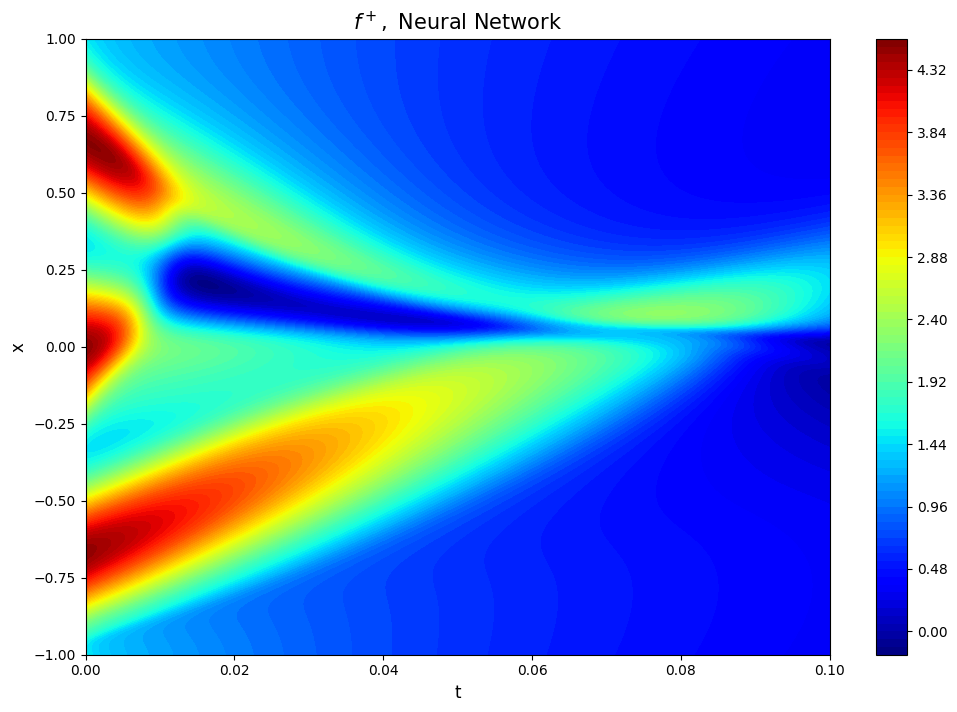

In [29]:
pred_f_plus = (preds_dict["f_plus"]).numpy()
f_plus_nn = pred_f_plus.reshape((m+1,n+1))
# f plus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_plus_nn, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^+,$ Neural Network',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_plus_nn.jpg', dpi=300)

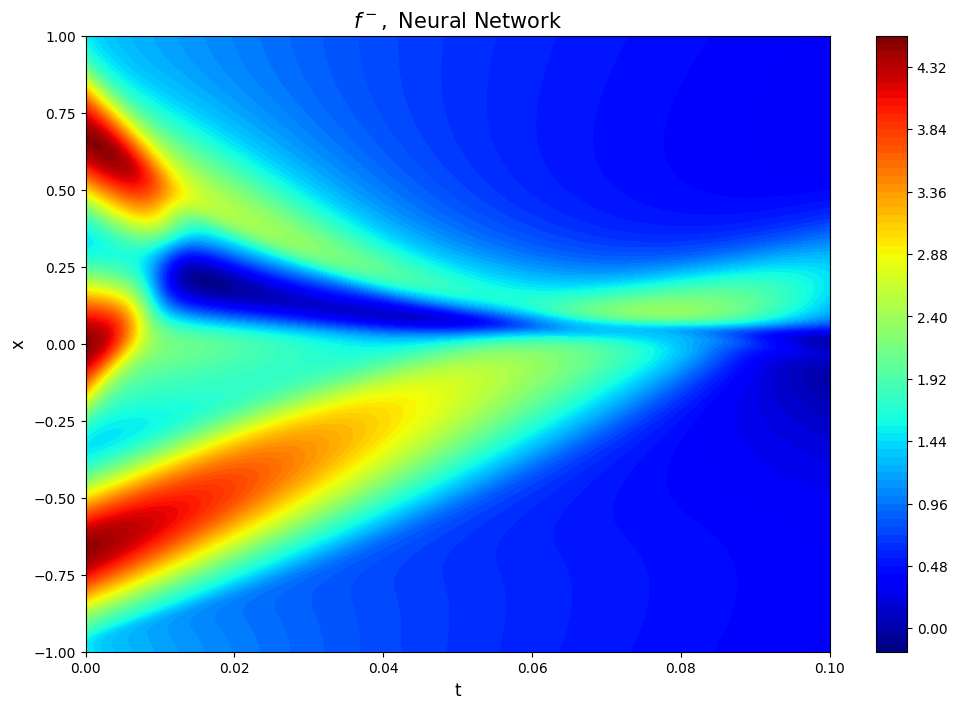

In [30]:
pred_f_minus = (preds_dict["f_minus"]).numpy()
f_minus_nn = pred_f_minus.reshape((m+1,n+1))
# f minus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_minus_nn, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^-,$ Neural Network',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_minus_nn.jpg', dpi=300)